# OSA-CASE STUDY

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from six import StringIO 
from IPython.display import Image
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

In [2]:
df = pd.read_excel("../DATA/OSA_EXTREME_DF_MALES_CLASSIFICATION.xlsx")

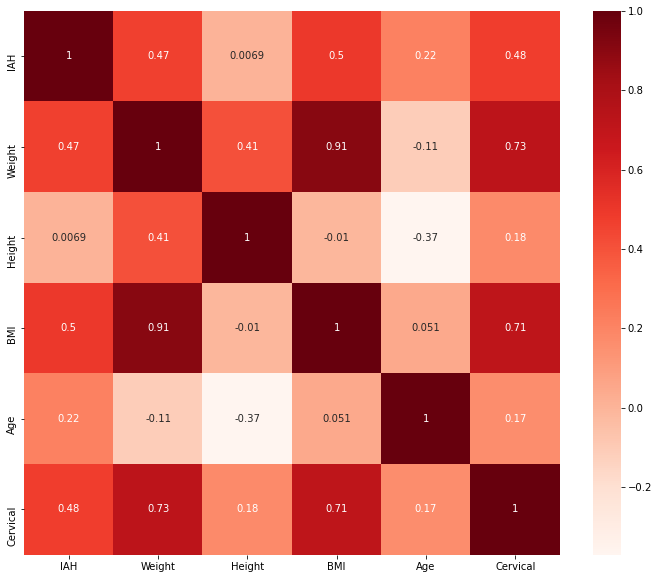

In [3]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Filter

In [4]:
List_Features = df.columns[2:]

for FEAT in List_Features:
    data1 = df[df['OSA'] == 'Healthy'][FEAT]
    data2 = df[df['OSA'] != 'Healthy'][FEAT]
    stat, p = mannwhitneyu(data1, data2)
    if p < 0.01:
        print("Feature: ", FEAT, " p-value: ", p)

Feature:  IAH  p-value:  3.234022518604387e-47
Feature:  OSA  p-value:  2.8348662938487176e-62
Feature:  Weight  p-value:  5.889654826850623e-09
Feature:  BMI  p-value:  3.3382264590712067e-12
Feature:  Age  p-value:  4.905602261178934e-07
Feature:  Cervical  p-value:  6.213669487573986e-12


In [5]:
i = 0
for name in df.iloc[:,np.r_[4:9]].columns:
    print('Features position: ',i, ' Name: ', name)
    i = i + 1

Features position:  0  Name:  Weight
Features position:  1  Name:  Height
Features position:  2  Name:  BMI
Features position:  3  Name:  Age
Features position:  4  Name:  Cervical


In [6]:
array = df.values
X = array[:,np.r_[4:9]]
Y = array[:,7]

In [7]:
selector = SelectKBest(score_func=f_classif, k=4)
selector.fit(X, Y)

/Users/isabel.rodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


SelectKBest(k=4)

In [8]:
scores = selector.pvalues_

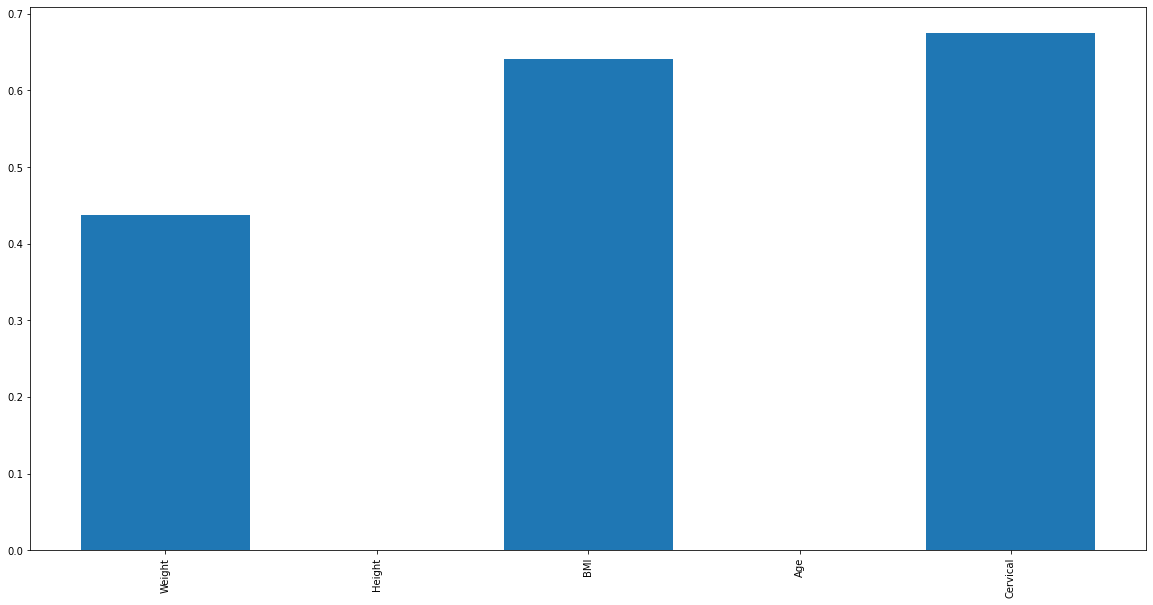

In [9]:
predictors = df.columns[np.r_[4:9]]

plt.figure(figsize=(20,10))
plt.bar(range(np.shape(X)[1]), scores)
plt.xticks(range(np.shape(X)[1]), predictors, rotation='vertical')
plt.show()

In [10]:
ifeat=0
for FEAT in predictors:
    p = selector.pvalues_[ifeat]
    ifeat = ifeat + 1
    if p < 0.05:
        print("Feature: ", FEAT, " p-value: ", p)

Feature:  Height  p-value:  1.0369108671967147e-05
Feature:  Age  p-value:  0.0


### wraper

In [11]:
array = df.values
X = array[:,np.r_[4:9]]
Y = array[:,7]
Y=Y.astype('int')

In [12]:
model = LogisticRegression(solver='liblinear')
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)

/Users/isabel.rodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Num Features: 5
Selected Features: [ True  True  True  True  True]


In [13]:
predictors = df.columns[np.r_[4:9]]

print("Selected Features: \n ", predictors[fit.support_])

Selected Features: 
  Index(['Weight', 'Height', 'BMI', 'Age', 'Cervical'], dtype='object')


In [14]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), predictors)))

Features sorted by their rank:
[(1, 'Age'), (1, 'BMI'), (1, 'Cervical'), (1, 'Height'), (1, 'Weight')]


In [15]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy', verbose=1)
rfecv.fit(X, Y)

Fitting estimator with 5 features.
Fitting estimator with 4 features.


/Users/isabel.rodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'), scoring='accuracy', verbose=1)

Optimal number of features : 1
Selected Features: 
  Index(['Age'], dtype='object')


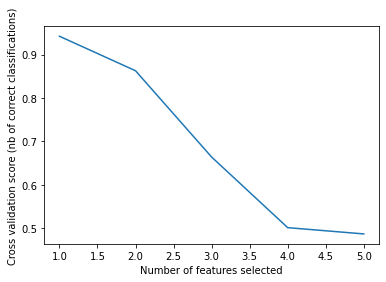

In [16]:

print("Optimal number of features : %d" % rfecv.n_features_)# Plot number of features VS. cross-validation scores

print("Selected Features: \n ", predictors[rfecv.support_])


plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### embedded

In [17]:
array = df.values
X = array[:,np.r_[4:9]]
Y = array[:,7]
Y=Y.astype('int')

In [18]:
scaler = StandardScaler()
scaler.fit(X)

sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l2'))
sel_.fit(scaler.transform(X), Y)

SelectFromModel(estimator=LogisticRegression(C=0.1))

In [19]:
sel_.get_support()

array([False,  True, False,  True, False])

In [20]:
predictors = df.columns[np.r_[4:9]]

print("Selected Features: \n ", list(predictors[sel_.get_support()]))

Selected Features: 
  ['Height', 'Age']


[Text(153.45000000000002, 190.26, 'X[3] <= 36.5\ngini = 0.973\nsamples = 277\nvalue = [1, 1, 1, 1, 6, 1, 2, 11, 9, 10, 9, 9, 7, 5\n9, 11, 8, 11, 4, 8, 5, 5, 8, 13, 13, 8, 5, 5\n7, 6, 6, 3, 5, 6, 6, 6, 4, 5, 3, 4, 4, 3\n3, 2, 1, 5, 4, 1, 1, 2, 2, 1, 1]'),
 Text(83.7, 135.9, 'X[3] <= 35.5\ngini = 0.863\nsamples = 61\nvalue = [1, 1, 1, 1, 6, 1, 2, 11, 9, 10, 9, 9, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(55.800000000000004, 81.53999999999999, 'X[3] <= 34.5\ngini = 0.842\nsamples = 52\nvalue = [1, 1, 1, 1, 6, 1, 2, 11, 9, 10, 9, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(27.900000000000002, 27.180000000000007, 'gini = 0.812\nsamples = 43\nvalue = [1, 1, 1, 1, 6, 1, 2, 11, 9, 10, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 

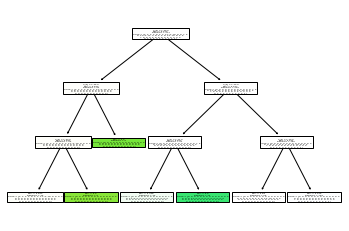

In [21]:
tree_model = DecisionTreeClassifier(max_depth=3).fit(X, Y)
plot_tree(tree_model, filled=True) 

In [26]:
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = df.columns[np.r_[4:9]].values)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png('OSA.png')
Image(graph.create_png())

In [27]:
RF_model = RandomForestClassifier(max_depth=10,min_samples_split=20).fit(X, Y)
RF_model.fit(X, Y)

RandomForestClassifier(max_depth=10, min_samples_split=20)

Feature ranking:
1. feature Age (0.582830)
2. feature Height (0.114671)
3. feature BMI (0.112140)
4. feature Weight (0.111454)
5. feature Cervical (0.078905)


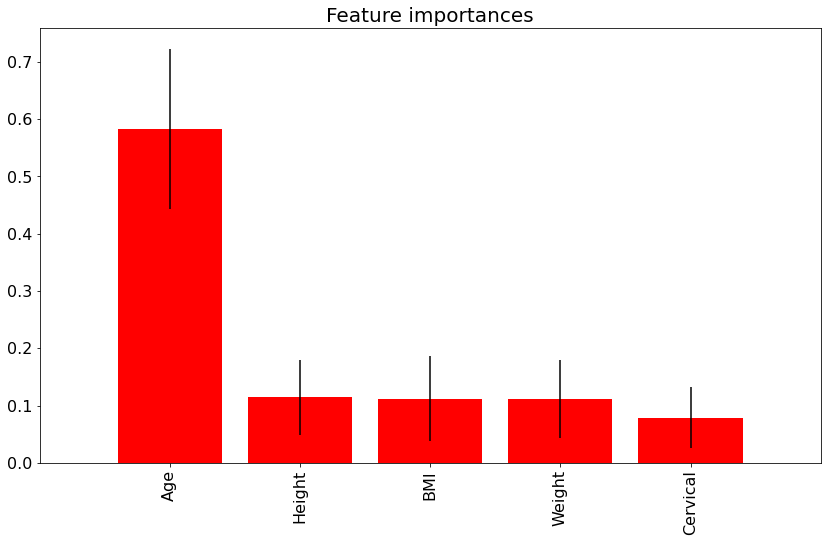

In [28]:
labels = df.iloc[:,np.r_[4:9]].columns
importances = RF_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(14,8))
plt.title("Feature importances", fontsize=20)
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [labels[k] for k in indices],rotation='vertical')
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.xlim([-1, X.shape[1]])
plt.show()